In [1]:
import numpy as np
from tqdm import tqdm
import multiprocessing as mp
import matplotlib.pyplot as plt

In [2]:
def generate_sequence(start, end_pos):
    """Generate a random sequence"""
    seq = [start]
    pos = start
    while pos!=0 and pos!=end_pos:
        if np.random.rand()<0.5:
            pos = pos-1
        else:
            pos = pos+1
        seq.append(pos)
    return seq

def update(w, seq, alpha, lm):
    """compute dw for each sequence"""
    n_state = len(w)
    dw = np.zeros([n_state])
    et = np.zeros([n_state])

    for t in range(len(seq)-1):
        de = np.zeros([n_state])
        de[seq[t]] = 1
        et = de + lm * et
        
        P0 = w[seq[t]] 
        P1 = w[seq[t+1]]
#         if t < len(seq)-1:
#             P1 = w[seq[t+1]]
#         else:
#             P1 = 1 if seq[-1]==n_state-1 else 0
            
        dw += alpha * (P1-P0) * et
        
    return dw

def rmse(w, w_true):
    return np.sqrt(np.mean((w-w_true)**2))

### Sanity Check
make sure $\omega$ converge to theortical value

In [3]:
n_state = 7
w_true = np.array([1/6.0, 1/3.0, 0.5, 2/3.0, 5/6.0])
w_mean = np.array([0]*7)
N=1000
for _ in range(N):
    w = np.array([0,0.5,0.5,0.5,0.5,0.5,1])
    for _ in range(100):
        seq = generate_sequence(3, n_state-1)
        w += update(w, seq, 0.2, 0.3)
    w_mean = w_mean + w/N
w_mean, rmse(w_mean[1:-1], w_true)

(array([0.        , 0.17228825, 0.33428855, 0.49998148, 0.66293232,
        0.83066431, 1.        ]), 0.0032736516287002826)

In [4]:
w = np.array([0,0.5,0.5,0.5,0.5,0.5,1])
for t in range(1,10000):
    seq = generate_sequence(3, n_state-1)
    w += update(w, seq, 0.3/t**0.6, 0.3)
w, rmse(w[1:-1], w_true)

(array([0.        , 0.17282769, 0.34214764, 0.5095607 , 0.66586766,
        0.83012005, 1.        ]), 0.00660334577588238)

### Experiment setup

In [5]:
training_size = 10
n_training_set = 100
lms = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
alphas = [0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6]
seqs = [[generate_sequence(3, n_state-1) for _ in range(training_size)] for _ in range(n_training_set)]

In [6]:
def training_1(alpha, lm, training_set):
    """
    experiment 1 training for each training set
    increment dw over seqs, update w once after every pass of training set
    repeat until w is converged on the given training_set
    """
    w = np.array([0,0.5,0.5,0.5,0.5,0.5,1])
    max_iteration = 10000

    for n in range(max_iteration):
        dw = np.zeros([n_state])
        for seq in training_set:
            dw += update(w, seq, alpha/len(training_set), lm)
        w += dw
        if np.linalg.norm(dw, 2) < 1e-5:
            break
    else:
        raise AssertionError("unconverged")
    error = rmse(w[1:-1], w_true)
    
    return error

def training_2(alpha, lm, training_set):
    """
    experiment 2 training for each training set
    update w for each seq in the training set
    only run a single pass for a given training set
    """
    w = np.array([0,0.5,0.5,0.5,0.5,0.5,1])
    for seq in training_set:
        w += update(w, seq, alpha, lm)
    error = rmse(w[1:-1], w_true)
    
    return error

def experiment_1(alpha, lm):
    """ compute the average and standard deviation of RMSE error for N training set"""
    errors = [training_1(alpha, lm, training_set) for training_set in tqdm(seqs)]
    return np.mean(errors), np.std(errors)

def experiment_2(alpha, lm):
    """ compute the average and standard deviation of RMSE error for N training set"""
    errors = [training_2(alpha, lm, training_set) for training_set in seqs]
    return np.mean(errors), np.std(errors)

### Experiment 1

In [7]:
pool = mp.Pool(mp.cpu_count())

errors = [pool.apply_async(experiment_1, args=(0.1, lm)) for lm in lms]
mean_error = [e.get()[0] for e in errors]
std_error = [e.get()[1]/np.sqrt(n_training_set) for e in errors]
print("maximum standard error:", round(max(std_error),5))

100%|██████████| 100/100 [00:18<00:00,  5.30it/s]


maximum standard error: 0.00923


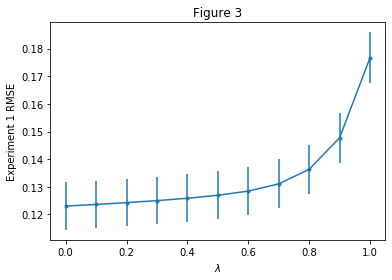

In [9]:
plt.errorbar(lms, mean_error, std_error, marker='.')
plt.xlabel("$\lambda$")
plt.ylabel("Experiment 1 RMSE")
plt.title("Figure 3")
plt.savefig("figure3.png")
plt.show()

### Experiment 2

In [10]:
initial_error = rmse(np.array([0.5]*5), w_true)

results = {'mean_error':{}, 'std_error':{}}
for lm in lms:
    results['mean_error'][lm] = {0: initial_error}
    results['std_error'][lm] = {0: 0}
    for alpha in alphas:
        mean, std = experiment_2(alpha, lm)
        results['mean_error'][lm][alpha] = mean
        results['std_error'][lm][alpha] = std/np.sqrt(n_training_set)

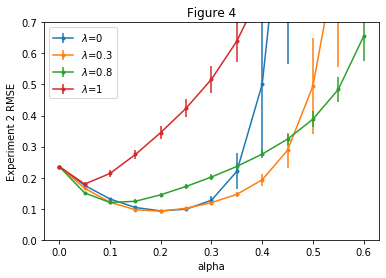

In [11]:
for lm in [0,0.3,0.8,1]:
    plt.errorbar(x = [0]+alphas, 
              y = results['mean_error'][lm].values(), 
              yerr = results['std_error'][lm].values(),
              label=f'$\lambda$={lm}', marker='.')
plt.legend()
plt.ylim(0,0.7)
plt.xlabel("alpha")
plt.ylabel("Experiment 2 RMSE")
plt.title("Figure 4")
plt.savefig("figure4.png")
plt.show()

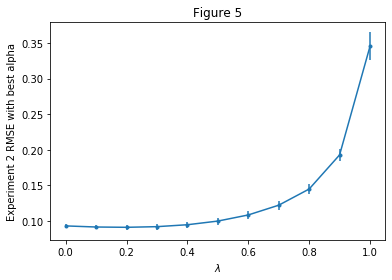

In [12]:
best_error, best_std_error = [], []
for lm in lms:
    best_alpha = min(results['mean_error'][0.1].items(), key = lambda x: x[1])[0]
    best_error.append(results['mean_error'][lm][best_alpha])
    best_std_error.append(results['std_error'][lm][best_alpha])

plt.errorbar(lms, best_error, best_std_error, marker='.')
plt.xlabel("$\lambda$")
plt.ylabel("Experiment 2 RMSE with best alpha")
plt.title("Figure 5")
plt.savefig("figure5.png")
plt.show()